In [1]:
# #@title Load Data from Dropbox

# !wget -O inputs6.csv https://www.dropbox.com/sh/xepz9yd20ga22xi/AAAHDrLxSkp48pQZEpBtDnZ2a/Bandwidth%2050MHz/23GHz/5percent/CSV_Data_Bandwidth50MHz_23GHz_input_5p.csv?dl=0
# !wget -O inputs7.csv https://www.dropbox.com/sh/xepz9yd20ga22xi/AACQ-nsHUkfN-mnhJfkQ1l3za/Bandwidth%2050MHz/21GHz/5percent/CSV_Data_Bandwidth50MHz_21GHz_input_5p.csv?dl=0
# !wget -O inputs8.csv https://www.dropbox.com/sh/xepz9yd20ga22xi/AAAZYx7ZcbOeMUqNi_aD7BiMa/Bandwidth%2050MHz/22GHz/5percent/CSV_Data_Bandwidth50MHz_22GHz_input_5p.csv?dl=0

In [2]:
#@title Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill

from sklearn.model_selection import train_test_split

import chillmax as cm
import chillmax.sampling

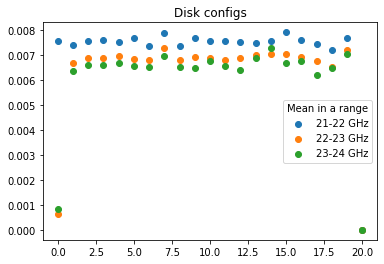

In [3]:
#@title Reading Data
hmm = []
for i in [7,8,6]:   
    dfi = pd.read_csv(f'inputs{i}.csv')
    hmm.append(dfi.to_numpy()[:5000])

fig, ax = plt.subplots()
for i in range(3):
        row = np.mean(hmm[i], axis=0)
        ax.scatter(range(len(row)), row, label='{}-{} GHz'.format(21+i, 22+i), c=f'C{i}')
ax.set_title('Disk configs')
ax.legend(title='Mean in a range');

In [4]:
#@title Generate configs to use in training

def gensparsecfgs(hmm, N=10):
    # Generate configs in gaps
    cfgs = np.vstack(hmm)
    los, his = np.min(cfgs, axis=0), np.max(cfgs, axis=0)
    new_cfgs = []
    for l, h in zip(los, his):
        new_cfgs.append(np.random.uniform(l, h , N))
    return np.vstack(new_cfgs).T
    
# Skip middle dataset for testing, but add random configs in that space
cfgs = np.vstack(hmm[::2] + [gensparsecfgs(hmm, N=5000)])
cfgs.shape

(15000, 21)

- train with boundary samples, exclude middle ground for real testing
- fill in enitrely randomly generated configs between the bounds

In [5]:
#@title Generate frequency sampling points

lfreqs = []
lcfgs = []
from tqdm import tqdm
for i in tqdm(np.random.choice(np.arange(len(cfgs)), size=8000)):
    # find peak widths
    spans = cm.sampling.get_spans(cfgs[i])
    if spans.all()==True:
        continue
    # For each cfg (with possibly more than 1 peak) generate a separate freqeuncy array and clone disk config
    f, c = cm.sampling.find_split_sampling(spans, cfgs[i])
    lfreqs.append(f)
    lcfgs.append(c)
    
    # Add some rough sampling for each config
    lfreqs.append(np.tile(np.linspace(21, 24, 200), (len(c), 1)))
    lcfgs.append(c)    

Sfreqs = np.vstack(lfreqs)
Scfgs = np.vstack(lcfgs)

100%|██████████| 8000/8000 [02:42<00:00, 49.20it/s]


In [6]:
#@title Generate boost factor curves given cfgs and frequency sampling points
def generate(freqs, cfgs):
    boosts = []
    from tqdm import tqdm
    for i, (freq, cfg) in enumerate(tqdm(zip(freqs, cfgs))):
        boosts.append(cm.sim.boost(freq*1e9, spacings=cfg))
    return np.vstack(boosts)
                      
boosts = generate(Sfreqs, Scfgs)

26720it [02:01, 219.53it/s]


In [7]:
#@title Check shapes
boosts.shape, Sfreqs.shape, Scfgs.shape

((26720, 200), (26720, 200), (26720, 21))

In [8]:
# Shuffle and split
X_train, X_test, f_train, f_test, y_train, y_test = train_test_split(Scfgs, 
                                                    Sfreqs,
                                                    boosts, 
                                                    test_size=0.1, shuffle=True)

In [9]:
#@title Reshape to predict single point (must be done after shuffling)
def flatten(Xs, ys, freqs):
    SIZE = np.asarray(ys).shape[0]
    NPTS = np.asarray(ys).shape[-1]
    fXs = np.empty((SIZE*NPTS, Xs.shape[-1]+1))
    for i in range(SIZE):
        fXs[i*NPTS:(i+1)*NPTS, :-1] = np.tile(Xs[i], (NPTS,1))
        fXs[i*NPTS:(i+1)*NPTS, -1] = freqs[i]
        
    fys = np.empty((SIZE*NPTS, 1))
    for i in range(SIZE):
        #fys[i*NPTS:(i+1)*NPTS, 0] = freqs[i]#np.arange(NPTS)
        fys[i*NPTS:(i+1)*NPTS, 0] = ys[i]
        
    return fXs, fys

# Do for both train and test
Xf_train, yf_train = flatten(X_train, y_train, f_train)
Xf_test, yf_test = flatten(X_test, y_test, f_test)

In [10]:
#@title Transform/preprocess
from sklearn.preprocessing import QuantileTransformer
scalerX = QuantileTransformer()
scalerY = QuantileTransformer()
Xs_train = scalerX.fit_transform(Xf_train) 
ys_train = scalerY.fit_transform(yf_train) 

Xs_test = scalerX.transform(Xf_test) 
ys_test = scalerY.transform(yf_test) 

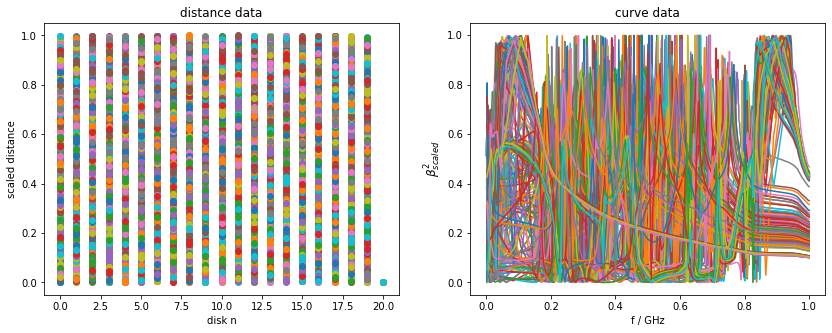

In [11]:
#@title Plot transformed
fig, axs = plt.subplots(1, 2, figsize=(14,5)) 
_size = 200
ixes = np.random.choice(np.arange(18000), size=500)
for i in ixes:    
    yax = Xs_train[i*_size:i*_size+_size][0][:-1]
    xax = range(len(yax))
    axs[0].scatter(xax, yax, label=i)
    axs[0].set_xlabel("disk n")
    axs[0].set_ylabel("scaled distance")
    xax = Xs_train[i*_size:(i+1)*_size][:, -1].T
    yax = ys_train[i*_size:i*_size+_size].T[0]
    axs[1].plot(xax, yax, label=i)
    axs[1].set_xlabel("f / GHz")
    axs[1].set_ylabel(r"$\beta^2_{scaled}$",fontsize=12)

axs[0].set_title("distance data")
axs[1].set_title("curve data");

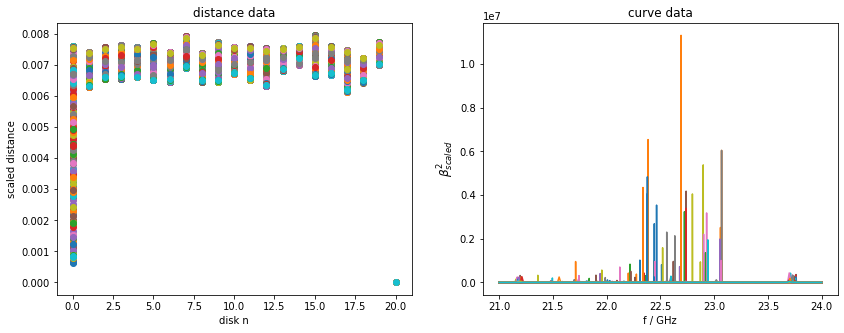

In [12]:
#@title Plot inverse transform roundtrip
fig, axs = plt.subplots(1, 2, figsize=(14,5)) 
Xsi = scalerX.inverse_transform(Xs_train)
ysi = scalerY.inverse_transform(ys_train)

for i in ixes:    
    yax = Xsi[i*_size:(i+1)*_size][0][:-1]
    xax = range(len(yax))
    axs[0].scatter(xax, yax, label=i)
    axs[0].set_xlabel("disk n")
    axs[0].set_ylabel("scaled distance")
        
    xax = Xsi[i*_size:(i+1)*_size][:, -1].T
    yax = ysi[i*_size:(i+1)*_size].T[0]
    axs[1].plot(xax, yax, label=i)
    axs[1].set_xlabel("f / GHz")
    axs[1].set_ylabel(r"$\beta^2_{scaled}$",fontsize=12)

axs[0].set_title("distance data")
axs[1].set_title("curve data");

In [13]:
# store state in case sth crashes
dill.dump_session('notebook_env.db')

In [1]:
import dill
dill.load_session('notebook_env.db')

In [2]:
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from scipy.signal import argrelextrema as ext
import tensorflow as tf

In [3]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [4]:
#@title Actual training
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Dense(500, input_dim=22, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))


    model.compile(optimizer = "adam", loss ='mae', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

    history=model.fit(Xs_train, ys_train, epochs=40, verbose=1,validation_split=0.2, batch_size=2048)

Epoch 1/40
1879/1879 [==============================] - 47s 25ms/step - loss: 0.1281 - mae: 0.1281 - root_mean_squared_error: 0.1838 - val_loss: 0.1085 - val_mae: 0.1085 - val_root_mean_squared_error: 0.1673
Epoch 2/40
1879/1879 [==============================] - 47s 25ms/step - loss: 0.0998 - mae: 0.0998 - root_mean_squared_error: 0.1531 - val_loss: 0.1044 - val_mae: 0.1044 - val_root_mean_squared_error: 0.1679
Epoch 3/40
1879/1879 [==============================] - 46s 25ms/step - loss: 0.0919 - mae: 0.0919 - root_mean_squared_error: 0.1442 - val_loss: 0.0968 - val_mae: 0.0968 - val_root_mean_squared_error: 0.1620
Epoch 4/40
1879/1879 [==============================] - 46s 24ms/step - loss: 0.0876 - mae: 0.0876 - root_mean_squared_error: 0.1392 - val_loss: 0.0944 - val_mae: 0.0944 - val_root_mean_squared_error: 0.1606
Epoch 5/40
1879/1879 [==============================] - 46s 24ms/step - loss: 0.0846 - mae: 0.0846 - root_mean_squared_error: 0.1357 - val_loss: 0.0943 - val_mae: 0.094

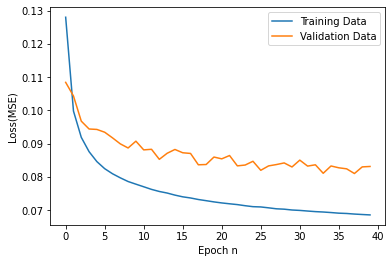

In [5]:
#@title Plot loss
plt.plot(history.history['loss'],label='Training Data')
plt.plot(history.history['val_loss'],label='Validation Data')
plt.xlabel("Epoch n")
plt.ylabel("Loss(MSE)")
plt.legend()

In [6]:
Xs_test.shape

(534400, 22)

In [7]:
predictions = model.predict(Xs_test)

In [8]:
predictions.shape

(534400, 1)

In [9]:
predi = scalerY.inverse_transform(predictions[:, 0].reshape(-1, 1))
predi_truth = scalerY.inverse_transform(ys_test)

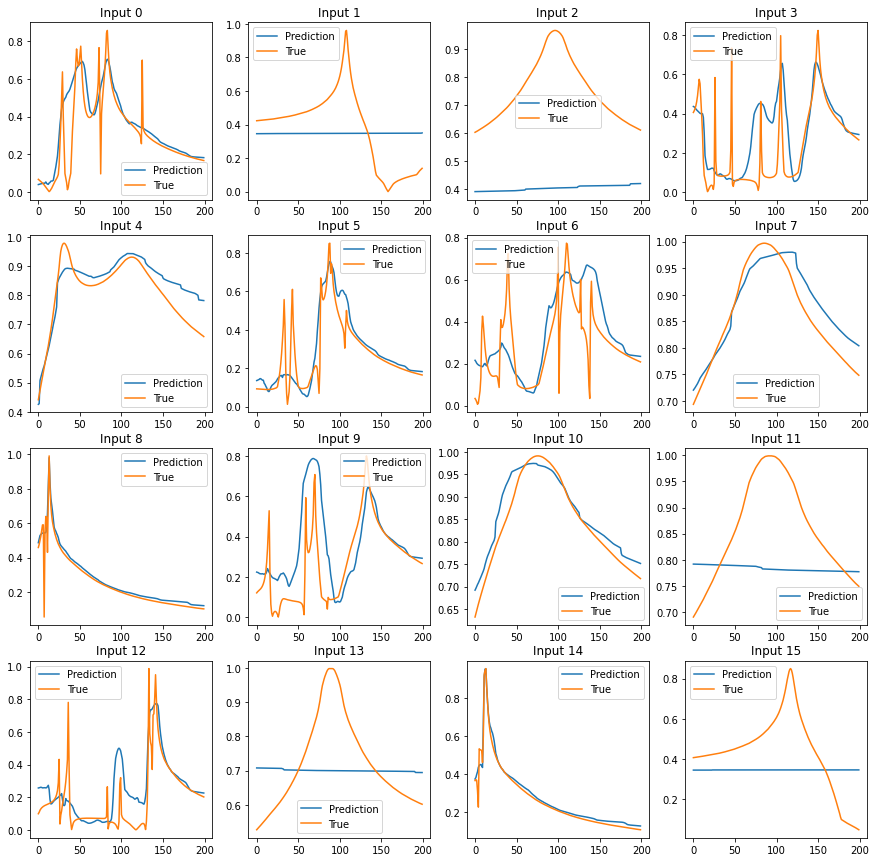

In [10]:
#@title Plot evaluation examples
fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.flatten()
_size = 200
ixes = np.random.choice(np.arange(int(len(predi)/_size)), size=16)
for i, ix in enumerate(ixes):
    axs[i].plot(range(_size), predictions[:, 0].reshape(-1, 1)[ix*_size:(ix+1)*_size], label="Prediction")
    axs[i].plot(range(_size), ys_test[ix*_size:(ix+1)*_size], label="True")
    axs[i].legend()
    axs[i].set_title(f"Input {i}")

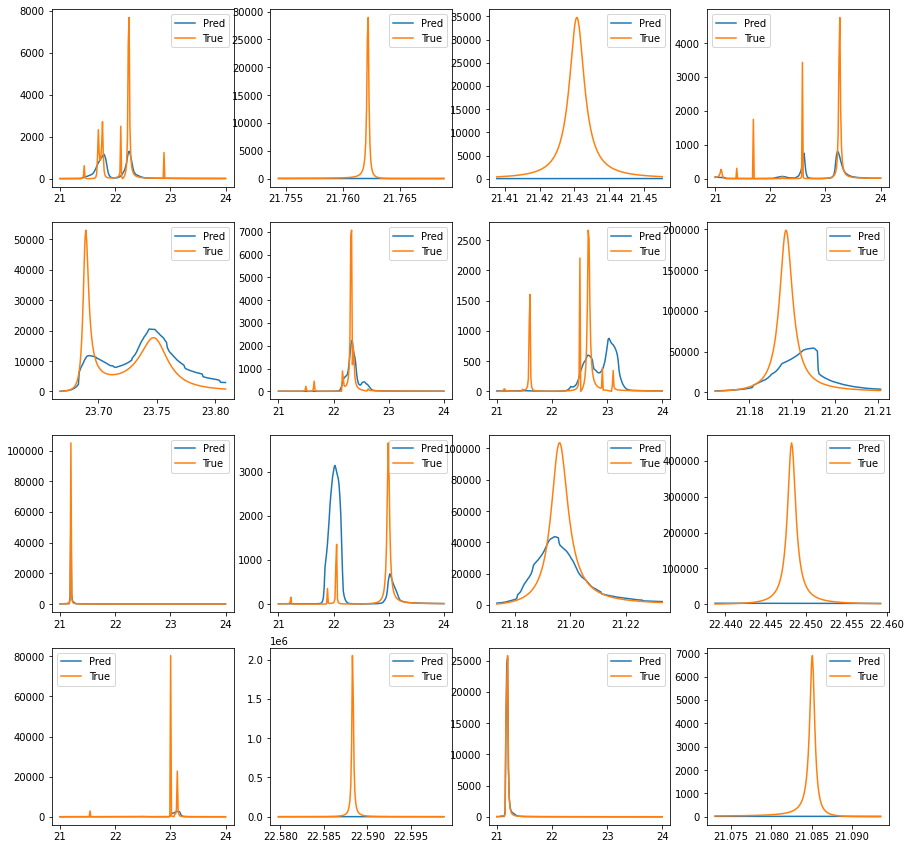

In [11]:
#@title Plot evaluation examples
from scipy.spatial.distance import jensenshannon as jsd

fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.flatten()
_size = 200
for i, ix in enumerate(ixes):
    xar = Xf_test[ix*_size:(ix+1)*_size][:, -1]
    _pred = predi[ix*_size:(ix+1)*_size]
    _tru = predi_truth[ix*_size:(ix+1)*_size]
    axs[i].plot(xar, _pred, label="Pred")
    axs[i].plot(xar, _tru, label="True")
    axs[i].legend()
    #axs[i].set_title(f"JSD {round(jsd(_tru, _pred),3)}")

## Let's try predicting at shifted points

In [12]:
A = Xf_test.copy()
B = Xf_test.copy()
C = Xf_test.copy()
SHIFT = 0.02 # Shift in GHz
A[:, -1] = A[:, -1] + SHIFT
B[:, -1] = B[:, -1] - SHIFT
C[:, -1] = np.tile(np.linspace(21, 24, 200), int(len(C[:, -1])/200))

As = scalerX.transform(A) 
Bs = scalerX.transform(B) 
Cs = scalerX.transform(C) 

In [13]:
As_pred = model.predict(As)[:, 0].reshape(-1, 1)
As_predi = scalerY.inverse_transform(As_pred)

Bs_pred = model.predict(Bs)[:, 0].reshape(-1, 1)
Bs_predi = scalerY.inverse_transform(Bs_pred)

Cs_pred = model.predict(Cs)[:, 0].reshape(-1, 1)
Cs_predi = scalerY.inverse_transform(Cs_pred)

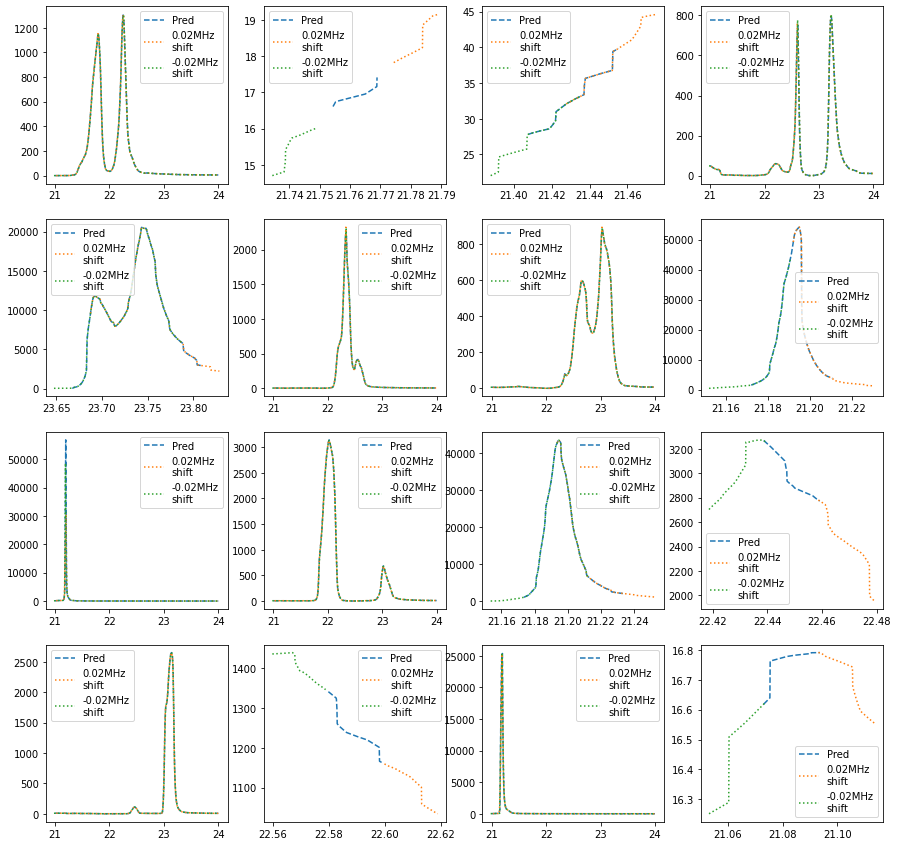

In [14]:
#@title Plot evaluation examples
from scipy.spatial.distance import jensenshannon as jsd

fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.flatten()
_size = 200
for i, ix in enumerate(ixes):
    xar = Xf_test[ix*_size:(ix+1)*_size][:, -1]
    _pred = predi[ix*_size:(ix+1)*_size]
    _shift_up = As_predi[ix*_size:(ix+1)*_size]
    _shift_down = Bs_predi[ix*_size:(ix+1)*_size]
    
    _general = Cs_predi[ix*_size:(ix+1)*_size]
    xar2 = C[ix*_size:(ix+1)*_size][:, -1]
    
    axs[i].plot(xar, _pred, label="Pred", ls='--')
    axs[i].plot(xar + SHIFT, _shift_up, label=f"{SHIFT}MHz\nshift", ls=':')
    axs[i].plot(xar - SHIFT, _shift_down, label=f"-{SHIFT}MHz\nshift", ls=':')
    #ax.plot(xar2, _general, label=f"wider", ls=':')
    axs[i].legend()

### Predict in between

In [15]:
# Fetch excluded dataset
cfgs = np.vstack(hmm[1])
cfgs.shape

# Generate freqs
lfreqs = []
lcfgs = []
_size = 1000
from tqdm import tqdm
for i in tqdm(np.random.choice(np.arange(600), size=500)):
    spans = cm.sampling.get_spans(cfgs[i])
    f, c = cm.sampling.find_split_sampling(spans, cfgs[i])
    #lfreqs.append(f)
    lfreqs.append(np.tile(np.linspace(22, 24, _size), (f.shape[0], 1)))
    lcfgs.append(c)

Tfreqs = np.vstack(lfreqs)
Tcfgs = np.vstack(lcfgs)
print(Tfreqs.shape, Tcfgs.shape)

# Generate boosts
def generate(freqs, cfgs):
    boosts = []
    from tqdm import tqdm
    for i, (freq, cfg) in enumerate(tqdm(zip(freqs, cfgs))):
        boosts.append(cm.sim.boost(freq*1e9, spacings=cfg))
    return boosts
                      
Tboosts = generate(Tfreqs, Tcfgs)

100%|██████████| 500/500 [00:09<00:00, 52.33it/s]
10it [00:00, 91.28it/s]

(567, 1000) (567, 21)


567it [00:06, 82.22it/s] 


In [16]:
_, X_t, _ , f_t, _, y_t = train_test_split(Tcfgs, 
                                           Tfreqs,
                                           Tboosts, 
                                           test_size=0.9, shuffle=False)

Xtf, ytf = flatten(X_t, y_t, f_t)

In [17]:
Xst = scalerX.transform(Xtf) 
Zpredictions = model.predict(Xst, batch_size=512)[:, 0].reshape(-1, 1)

Zpredi = scalerY.inverse_transform(Zpredictions)
Zpredi_truth = scalerY.inverse_transform(ys_test)

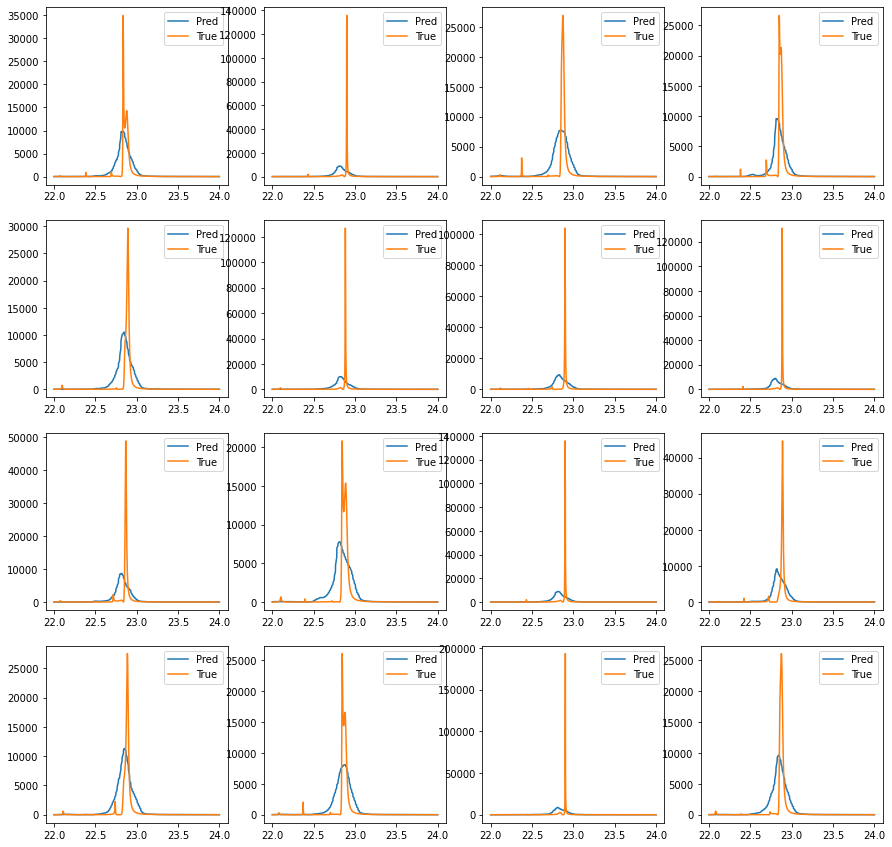

In [18]:
#@title Plot evaluation examples
from scipy.spatial.distance import jensenshannon as jsd

fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.flatten()
ixes = np.random.choice(np.arange(int(len(Zpredi)/_size)), size=16)
for i, ix in enumerate(ixes):    
    xar = Xtf[ix*_size:(ix+1)*_size][:, -1]
    _pred = Zpredi[ix*_size:(ix+1)*_size]
    _tru = Zpredi_truth[ix*_size:(ix+1)*_size]
    axs[i].plot(xar, _pred, label="Pred")
    #axs[i].plot(xar, _tru, label="True")
    axs[i].plot(xar, cm.sim.boost(xar*1e9, spacings=Xtf[ix*_size:(ix+1)*_size][0][:-1]), label="True")
    
    axs[i].legend()
    #axs[i].set_title(f"JSD {round(jsd(_pred, _tru),3)}")